## Trabalho 1 - Fundamentos de Análise de Dados
### Implementação do algoritmo k-NN para k=1, utilizando a distância euclidiana e a distância de Mahalanobis 
#### Dataset: 'Mnist Sign Lang'

In [3]:
# importando as bibliotecas utilizadas no código

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2 
import math

### Funções 

#### Funções de Manipulação de Dados

In [4]:
arq_train = 'sign_mnist_train.csv'
arq_test = 'sign_mnist_test.csv'

In [5]:
def get_all_df():
    """
    Carrega os conjuntos de dados de treinamento e teste e retorna DataFrames correspondentes.

    Retorna:
    (pandas.DataFrame, pandas.DataFrame): Um par de DataFrames contendo os conjuntos de dados de treinamento e teste, respectivamente.
    """
    df_train = pd.read_csv(arq_train)
    df_test = pd.read_csv(arq_test)
    df_test.drop(df_test.index[0], inplace=True)
    return df_train, df_test

def get_total_df():
    """
    Carrega os conjuntos de dados de treinamento e teste e retorna DataFrames correspondentes.

    Retorna:
    (pandas.DataFrame): Um DataFrames contendo todo o conjuntos de dados de treinamento e de teste
    """
    df_train, df_test = get_all_df()
    concatenated_df = pd.concat([df_train, df_test], axis=0) 
    return concatenated_df

def get_x(tam, arq):
    """
    Seleciona um tamanho específico do dataset e retorna a matriz X de treinamento ou de teste

    Parâmetros:
    tam (int): tamanho da amostra a ser utilizada no experimento
    arq (str): o caminho do arquivo CSV contendo os dados (pode ser o de treino ou o de teste)

    Retorna:
    numpy.ndarray: matriz X de quantidade tam de amostras do dataset.
    """
    df = pd.read_csv(arq)
    df.drop(df.index[tam+1:], inplace=True)
    df.drop(df.index[0], inplace=True)
    df.drop(columns=['label'], inplace=True)
    
    X = np.asarray(df)
    return X

def get_y(tam, arq):
    """
    Retorna:
    numpy.array: vetor Y de quantidade tam de amostras do dataset.
    """
    df = pd.read_csv(arq)
    df.drop(df.index[tam:], inplace=True)
    label = df['label']
    y = np.asarray(label)
    return y

def get_x_y(tam_total):
    """
    Divide o dataset em conjunto de treinamento e teste e retorna os conjuntos X e y 

    Parâmetros:
    tam_total (int): O tamanho total do conjunto de dados.

    Retorna:
    numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray: Conjuntos X_train, X_test, y_train e y_test 
    """
    tam_train = int(0.7 * tam_total)
    tam_test = (tam_total - tam_train)

    X_train = get_x(tam_train, arq_train)
    y_train = get_y(tam_train, arq_train)

    X_test = get_x(tam_test, arq_test)
    y_test = get_y(tam_test, arq_test)

    return X_train, X_test, y_train, y_test

In [19]:
def get_img(index : int = 0):
    """
    Imprime uma das imagens do dataset (escolhido o de treino arbitrariamente)

    Parâmetros:
    index: posição do vetor da imagem específica no dataset
    """
    df,_ = get_all_df() 
    print(f"Classe dessa imagem: {df['label'].iloc[index]}")

    df.drop(columns=['label'], inplace=True)
    img = np.asarray(df.iloc[index])

    img = img.reshape((28, 28))
    plt.imshow(img, cmap="gray")
    plt.show()

def print_img(img):
    img.drop(columns=['label'], inplace=True)
    img = np.asarray(img)
    
    img = img.reshape((28, 28))
    plt.imshow(img, cmap="gray")
    plt.show()

Preprocessamento de imagem (objetivo: melhorar custo computacional)

In [26]:
def converting_img(img):
    final_img = img/255
    return final_img

def convert_dataset(dataset):
    """
    Realizando o procedimento de pré-processamento em todas as imagens do dataset conjugado 

    Parâmetros:
    dataset: recebe o dataset (DataFrame) cujo qual as imagens vão ser preprocessadas
    """
    dataset.drop(columns=['label'], inplace=True)
    dataset = np.asarray(dataset)
    arr1 = dataset[0]
    img_example = arr1
    pixels = img_example.reshape((28, 28))
    pixels = pixels/255
    pixels = pixels.flatten() 

    processed_images = np.array([pixels])
    for index, arr in enumerate(dataset):
        if index == 0:
            continue
        img_example = arr
        pixels = img_example.reshape((28, 28))
        
        pixels = pixels/255
        
        pixels = pixels.flatten() 
        processed_images = np.append(processed_images, [pixels], axis=0)

    return processed_images

#### Funções de Operações

In [34]:
def identidade(matrix, tol=1e-10):
  
    if len(matrix) != len(matrix[0]):
        return False
    
    n = len(matrix)
    
    for i in range(n):
        for j in range(n):
            if i == j and not math.isclose(matrix[i][j], 1, abs_tol=tol):
                return False
            elif i != j and not math.isclose(matrix[i][j], 0, abs_tol=tol):
                return False
    
    print("Essa matriz é identidade")
    return

#### Funções de cálculo do KNN

In [37]:
def euclidian_distance(x, y):
    len_x = len(x)
    len_y = len(y)
    if (len_x < len_y):
        x.resize(len_y, refcheck=False)
        x[len_x:(len_y-1)] = 0
    elif (len_y < len_x):
        y.resize(len_x, refcheck=False)
        y[len_y:(len_x-1)] = 0
    if( len(x) == len(y)):
        diff = 0
        for index, value_x in enumerate(x):
            diff+=(value_x-y[index])*(value_x-y[index])
        return np.sqrt(diff)
    else:
        return False


def mahalanobis_distance(x, y, covariance_matrix):
    diff = x - y

    cov_inv = np.linalg.inv(covariance_matrix)
    
    dist = np.sqrt(np.dot(np.dot(diff.T, cov_inv), diff))
    
    return dist


def knn_mahalanobis (x_train, x_test, y_train, cov):
    classes_prediction = []
    for test_vector in x_test:
        distances_classes = []
        for index, train_vector in enumerate(x_train):
            dist = mahalanobis_distance(train_vector, test_vector, cov)
            distances_classes.append((dist, y_train[index]))
        distances_classes.sort()
        classes_prediction.append(distances_classes[0][1])
    print(classes_prediction)
    return classes_prediction

def knn_euclidian (x_train, x_test, y_train):
    classes_prediction = []
    for test_vector in x_test:
        distances_classes = []
        for index, train_vector in enumerate(x_train):
            # essa distância euclidiana foi comparada com a do scipy
            dist = euclidian_distance(train_vector, test_vector)
            distances_classes.append((dist, y_train[index+1]))
        distances_classes.sort()
        classes_prediction.append(distances_classes[0][1])
    return classes_prediction

def S_matrix (train_matrix, test_matrix):
    dataset = np.concatenate((train_matrix, test_matrix))

    arr1 = dataset[0]
    img_example = arr1
    pixels = img_example.reshape((28, 28))
    pixels = pixels/255
    pixels = pixels.flatten() 

    processed_images = np.array([pixels])
    for index, arr in enumerate(dataset):
        if index == 0:
            continue
        img_example = arr
        pixels = img_example.reshape((28, 28))
        
        pixels = pixels/255
        
        pixels = pixels.flatten() 
        processed_images = np.append(processed_images, [pixels], axis=0)

    cov_X = np.cov(processed_images, rowvar=False)

    rank = np.linalg.matrix_rank(cov_X)

    if (rank != 784):
        return

    else:
        inv_X = np.linalg.inv(cov_X)
        return inv_X

### Visualização dos Dados
#### Banco de Dados:  [Sign Language - Mnist](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)
Esse banco de dados consiste em vetores que representam imagens de 784 pixels cada que estão na escala RGB (ou seja, casa pixel possui um valor inteiro entre 0 e 255, onde 0 é um pixel branco e 255, um pixel preto), que formam uma imagem de formato 28 x 28

Essas imagens foram retiradas de um banco de dados mais completo, cortadas para aparecerem apenas as mãos, reduzidas a escala de cinza e reformatadas. 


In [6]:
df = get_total_df()

df.head(15)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


In [7]:
df.shape

(34626, 785)

O conjunto de dados possui uma coluna de label que é a classificação da imagem. A classificação consiste em um número de 0 a 25 (sem '9': J e sem '25': Z, pois os gestos dessas letras requerem movimentação das mãos e não podem ser representados nas imagens), que idenfica aquela imagem como uma letra do alfabeto, sendo 1, a letra 'a', 2, a letra 'b', e assim sucessivamente.

In [8]:
df['label'].head(20)

0      3
1      6
2      2
3      2
4     13
5     16
6      8
7     22
8      3
9      3
10    18
11    10
12    16
13    22
14    20
15    16
16    17
17    13
18    13
19    19
Name: label, dtype: int64

Como a imagem é representada no dataset

In [9]:
df.head(1)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202


Exemplo de imagem (no caso, um G)

Classe dessa imagem: 6


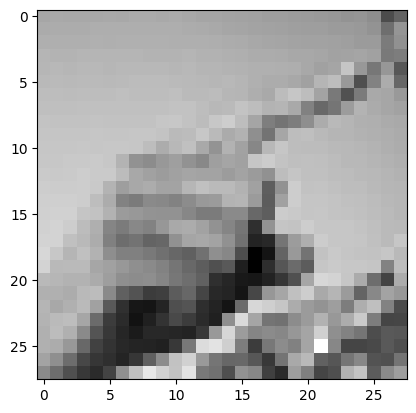

In [10]:
get_img(1)

#### Preprocessamento da imagem 
Os pixels da imagem, antes de 0 a 255 agora estão no intervalo de 0 e 1. Esse recurso foi utilizado afim de melhorar custo computacional do programa. É possível ver que a imagem ainda pode ser printada mesmo após esse tratamento:

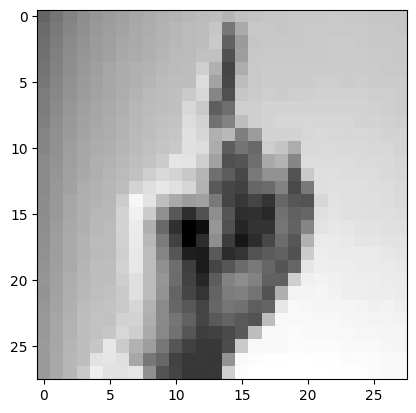

In [20]:
img = converting_img(df.head(1))
print_img(img)

### KNN

### Distância de Mahalanobis

##### Cálculo da matriz S
Para o cálculo da Distância de Mahalanobis, é necessário calcular a inversa da matriz S de covariância do banco de dados. O processo é descrito a seguir, com o dataset completo:

Primeiramente o dataset tem suas imagens preprocessadas:

In [28]:
df = get_total_df()
converted_dataset = convert_dataset(df)
print(converted_dataset)


[[0.41960784 0.4627451  0.49803922 ... 0.8        0.79607843 0.79215686]
 [0.60784314 0.61568627 0.61176471 ... 0.40392157 0.52941176 0.58431373]
 [0.73333333 0.7372549  0.7372549  ... 0.76470588 0.76078431 0.76470588]
 ...
 [0.74509804 0.74901961 0.74509804 ... 0.82745098 0.81960784 0.81568627]
 [0.78823529 0.80392157 0.81568627 ... 0.2627451  0.2745098  0.24705882]
 [0.67843137 0.68235294 0.67843137 ... 0.76470588 0.75686275 0.75294118]]


Segundamente a matriz de covariância é calculada 

In [30]:
# Calculando a matriz de covariância do dataset 

cov_X = np.cov(converted_dataset, rowvar=False)
print(cov_X.shape)


(784, 784)


Depois disso é feito um processo de verificação da matriz de covariância (esse processo é feito também na função de cálculo de covariância dos testes):
Verificando o posto da matriz. Ela precisa ser posto máximo (784, quantidade de colunas), para que possa ter determinante 0 e ser invertível para o cálculo da distância de Mahalanobis

In [31]:
rank = np.linalg.matrix_rank(cov_X)
print(rank)

784


Verificando o determinante da matriz de covariância com slogdet, indicada para matrizes de tamanho grande, pois utilizando a função det o resultado não era satisfatório (era sempre 0)

In [32]:
print(cov_X.shape)
det_X = np.linalg.slogdet(cov_X)
print(det_X)

(784, 784)
SlogdetResult(sign=1.0, logabsdet=-5381.773898632859)


Aqui a inversa é calculada e também verificada com a função identidade que tem como objetivo retornar se p (o produto das matrizes de covariância com a sua respectiva inversa) é identidade

In [36]:
inv_X = np.linalg.inv(cov_X)

p = np.dot(cov_X, inv_X)

identidade(p)

Essa matriz é identidade


#### Cálculo da Distância de Mahalanobis
Nesta sessão serão feitos alguns testes com o KNN com a Distância de Mahalanobis, uma vez que não foi possível calcular o KNN do dataset total para essa distância em tempo hábil, por conta do tamanho do dataset e dos cálculos custosos entre matrizes 

##### Teste das funções (10 amostras apenas)

In [ ]:
arr1 = train_matrix[0]
img_example = arr1
pixels = img_example.reshape((28, 28))
pixels = pixels/255
pixels = pixels.flatten() 

processed_train = np.array([pixels])
for index, arr in enumerate(train_matrix):
    if index == 0:
        continue
    img_example = arr
    pixels = img_example.reshape((28, 28))
    
    pixels = pixels/255

    
    pixels = pixels.flatten() 
    processed_train = np.append(processed_train, [pixels], axis=0)

print(processed_train)

arr1 = test_matrix[0]
img_example = arr1
pixels = img_example.reshape((28, 28))
pixels = pixels/255
pixels = pixels.flatten() 

processed_test = np.array([pixels])
for index, arr in enumerate(test_matrix):
    if index == 0:
        continue
    img_example = arr
    pixels = img_example.reshape((28, 28))
    
    pixels = pixels/255

    pixels = pixels.flatten() 
    processed_test = np.append(processed_test, [pixels], axis=0)

print(processed_test)


[[0.60784314 0.61568627 0.61176471 ... 0.40392157 0.52941176 0.58431373]
 [0.73333333 0.7372549  0.7372549  ... 0.76470588 0.76078431 0.76470588]
 [0.82745098 0.82745098 0.83137255 ... 0.87058824 0.89803922 0.63921569]
 ...
 [0.58431373 0.59607843 0.60392157 ... 0.09411765 0.09019608 0.08627451]
 [0.4627451  0.48235294 0.49803922 ... 0.78431373 0.78039216 0.78039216]
 [0.         0.10196078 0.18039216 ... 0.71372549 0.71372549 0.71764706]]
[[0.49411765 0.50196078 0.51372549 ... 0.72156863 0.71372549 0.70588235]
 [0.33333333 0.34509804 0.36078431 ... 0.88235294 0.87843137 0.87058824]
 [0.79607843 0.80392157 0.81176471 ... 0.94117647 0.99215686 1.        ]
 ...
 [0.38823529 0.42745098 0.46666667 ... 0.4627451  0.5254902  0.6       ]
 [0.65098039 0.65098039 0.65882353 ... 0.61176471 0.54509804 0.38431373]
 [0.85882353 0.85882353 0.87058824 ... 0.16078431 0.16470588 0.16470588]]


In [ ]:
%%time

def mahalanobis_distance(x, y, covariance_matrix):
    diff = x - y

    cov_inv = np.linalg.inv(covariance_matrix)
    
    distance = np.sqrt(np.dot(np.dot(diff.T, cov_inv), diff))
    
    return distance


def knn (x_train, x_test, y_train, cov):
    classes_prediction = []
    for test_vector in x_test:
        distances_classes = []
        for index, train_vector in enumerate(x_train):
            dist = mahalanobis_distance(train_vector, test_vector, cov)
            distances_classes.append((dist, y_train[index]))
        distances_classes.sort()
        classes_prediction.append(distances_classes[0][1])
    print(classes_prediction)
    return classes_prediction


prediction = knn(train_matrix, test_matrix, classes_arr, cov_X)

[0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 20, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 21, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 21, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 16, 0, 0, 0, 0, 16, 16, 0, 0, 0, 0, 0, 21, 21, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 16, 0, 0, 0, 0, 16, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: total: 59min 35s
Wall time: 2h 54min 31s


In [ ]:
def data (tam_train, tam_test):
    train = pd.read_csv('sign_mnist_train.csv')

    classes_arr = train['label']

    train.drop(train.index[tam_train:], inplace=True)
    train.drop(train.index[0], inplace=True)
    train.drop(columns=['label'], inplace=True)

    train_matrix = np.asarray(train)

    test = pd.read_csv('sign_mnist_test.csv')

    test_classes_arr = test['label']

    test_ini = tam_train+1
    test_fi = tam_train+tam_test+1
    test.drop(test.index[test_ini:test_fi], inplace=True)
    test.drop(test.index[0], inplace=True)
    test.drop(columns=['label'], inplace=True)

    test_matrix = np.asarray(test)

    return classes_arr, train_matrix, test_classes_arr, test_matrix

def S_matrix (train_matrix, test_matrix):
    dataset = np.concatenate((train_matrix, test_matrix))

    arr1 = dataset[0]
    img_example = arr1
    pixels = img_example.reshape((28, 28))
    pixels = pixels/255
    pixels = pixels.flatten() 

    processed_images = np.array([pixels])
    for index, arr in enumerate(dataset):
        if index == 0:
            continue
        img_example = arr
        pixels = img_example.reshape((28, 28))
        
        pixels = pixels/255
        
        pixels = pixels.flatten() 
        processed_images = np.append(processed_images, [pixels], axis=0)

    cov_X = np.cov(processed_images, rowvar=False)

    rank = np.linalg.matrix_rank(cov_X)

    if (rank != 784):
        return

    else:
        inv_X = np.linalg.inv(cov_X)
        return inv_X

def mahalanobis_distance(x, y, covariance_matrix):
    diff = x - y

    cov_inv = np.linalg.inv(covariance_matrix)
    
    distance = np.sqrt(np.dot(np.dot(diff.T, cov_inv), diff))
    
    return distance


def knn (x_train, x_test, y_train, cov):
    classes_prediction = []
    for test_vector in x_test:
        distances_classes = []
        for index, train_vector in enumerate(x_train):
            dist = mahalanobis_distance(train_vector, test_vector, cov)
            distances_classes.append((dist, y_train[index]))
        distances_classes.sort()
        classes_prediction.append(distances_classes[0][1])
    print(classes_prediction)
    return classes_prediction

def calculo_mahalanobis(train_matrix, test_matrix, classes_arr, cov_X):
    arr1 = train_matrix[0]
    img_example = arr1
    pixels = img_example.reshape((28, 28))
    pixels = pixels/255
    pixels = pixels.flatten() 

    processed_train = np.array([pixels])
    for index, arr in enumerate(train_matrix):
        if index == 0:
            continue
        img_example = arr
        pixels = img_example.reshape((28, 28))
        
        pixels = pixels/255

        
        pixels = pixels.flatten() 
        processed_train = np.append(processed_train, [pixels], axis=0)

    arr1 = test_matrix[0]
    img_example = arr1
    pixels = img_example.reshape((28, 28))
    pixels = pixels/255
    pixels = pixels.flatten() 

    processed_test = np.array([pixels])
    for index, arr in enumerate(test_matrix):
        if index == 0:
            continue
        img_example = arr
        pixels = img_example.reshape((28, 28))
        
        pixels = pixels/255

        pixels = pixels.flatten() 
        processed_test = np.append(processed_test, [pixels], axis=0)

    prediction = knn(processed_train, processed_test, classes_arr, cov_X)
    return prediction


def test_mahalanobis(tam_train, tam_test):
    classes_arr, train_matrix, test_classes_arr, test_matrix = data(tam_train, tam_test)
    S = S_matrix(train_matrix, test_matrix)
    resultado = calculo_mahalanobis(train_matrix, test_matrix, classes_arr, S)
    return resultado


In [ ]:
%%time
resultado_100 = test_mahalanobis(71, 31)
print(resultado_100)


KeyboardInterrupt: 

In [ ]:
%%time
resultado_1000 = test_mahalanobis(701, 301)
print(resultado_1000)


KeyboardInterrupt: 

In [ ]:
%%time
resultado_3000 = test_mahalanobis(2101, 901)
print(resultado_3000)

In [ ]:
DF = pd.DataFrame(prediction) 
DF.to_csv("prediction_mahalanobis.csv")

NameError: name 'pd' is not defined

In [ ]:
def euclidian_distance(x, y):
    len_x = len(x)
    len_y = len(y)
    if (len_x < len_y):
        x.resize(len_y, refcheck=False)
        x[len_x:(len_y-1)] = 0
    elif (len_y < len_x):
        y.resize(len_x, refcheck=False)
        y[len_y:(len_x-1)] = 0
    if( len(x) == len(y)):
        diff = 0
        for index, value_x in enumerate(x):
            diff+=(value_x-y[index])*(value_x-y[index])
        return np.sqrt(diff)
    else:
        raise Exception("Seomething went wrong with euclidian distance")

def knn (x_train, x_test, y_train):
    classes_prediction = []
    for test_vector in x_test:
        distances_classes = []
        for index, train_vector in enumerate(x_train):
            # this euclidian_distance was compared with the euclidian function from scipy
            dist = euclidian_distance(train_vector, test_vector)
            distances_classes.append((dist, y_train[index+1]))
        distances_classes.sort()
        classes_prediction.append(distances_classes[0][1])
    return classes_prediction

In [ ]:
DF = pd.DataFrame(classes_prediction) 
DF.to_csv("prediction_euclidian.csv")

NameError: name 'classes_prediction' is not defined